# Performance Benchmarks

The ``plscan`` library is a re-implementation of the ``fast_hdbscan`` library,
while retaining most of the features from the classic ``hdbscan`` library. In
this notebook, we compare the computational performance of these libraries.
Since all three implementations use *space trees*, we are particularly
interested in understanding how their performance changes as the number of
dimensions increases.

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.datasets import make_blobs

from plscan import PLSCAN
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from fast_hdbscan import HDBSCAN as FastHDBSCAN

from lib.plotting import *

_ = configure_matplotlib()

To make things easily repeatable we'll write a simple benchmarking function that
can time how long it takes the different implementations to run on the same
randomly generated dataset. To generate the datasets we'll just use
``make_blobs`` from sklearn. This will not produce the most interesting datasets
for clustering, but it will be good enough to benchmark runtimes. Since we will
be interested in varying the dimension of the dataset we'll leave that as a
parameter, and we'll scale the size of the blobs accordingly (there is more
space in high dimensions so we can have a larger standard deviation on the
blobs) to make it more realistic.

In [2]:
def benchmark(
    data_sizes,
    dimensions,
    alg_classes,
    alg_params,
    alg_names,
    *,
    n_clusters=100,
    n_runs=5,
    min_samples=10,
    min_cluster_size=100,
    timeout=20,
):
    rows = []
    pbar = tqdm(total=n_runs * len(data_sizes) * len(dimensions) * len(alg_classes))
    for d in dimensions:
        max_size = {}
        for n_samples in data_sizes:
            min_cluster_size = min(n_samples // n_clusters, min_cluster_size)
            for n in range(n_runs):
                data_sample, _ = make_blobs(
                    n_samples=n_samples,
                    n_features=d,
                    centers=n_clusters,
                    cluster_std=min((10**d / (n_clusters * 9)), 2.0),
                )
                for Alg, param, name in zip(alg_classes, alg_params, alg_names):
                    # Skip algorithms that took too long on previous runs
                    if n_samples >= max_size.get(name, np.inf):
                        pbar.update()
                        continue

                    if name == "kmeans":
                        start_time = time.time()
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            model = Alg(n_clusters=n_clusters, **param).fit_predict(
                                data_sample
                            )
                        elapsed = time.time() - start_time
                    else:
                        start_time = time.time()
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            model = Alg(
                                min_samples=min_samples,
                                min_cluster_size=min_cluster_size,
                                **param,
                            ).fit_predict(data_sample)
                        elapsed = time.time() - start_time
                    if elapsed > timeout:
                        max_size[name] = n_samples
                    rows.append((name, n_samples, d, n, elapsed))
                    pbar.update()

    return pd.DataFrame(
        rows, columns=("algorithm", "n_samples", "n_features", "run", "elapsed_time")
    )

With that in hand we can run the benchmark. For reference this notebook was run
on an 8-core machine. If you have fewer cores you'll see less improvement, and
if you have more cores, well, things will only look better.

In [5]:
timeout = 20
dimensions = [2, 5, 10, 15, 20]
data_sizes = [5000, 10000, 20000, 40000, 80000, 160000, 320000, 640000, 1280000]
alg_classes = [PLSCAN, PLSCAN, FastHDBSCAN, HDBSCAN, KMeans]
alg_params = [{}, {"space_tree": "ball_tree"}, {}, {}, {}]
alg_names = [
    "plscan (kd-tree)",
    "plscan (ball-tree)",
    "fast_hdbscan",
    "hdbscan",
    "kmeans",
]

In [4]:
benchmark_results = benchmark(
    data_sizes, dimensions, alg_classes, alg_params, alg_names, timeout=timeout
)
benchmark_results.to_parquet("data/generated/benchmark_time.parquet", index=False)

100%|██████████| 1125/1125 [37:24<00:00,  1.99s/it] 


In [9]:
from importlib.metadata import version
for name in ['plscan', 'hdbscan', 'fast_hdbscan', 'scikit-learn']:
    print(name, version(name))

plscan 0.1.dev19+g9d1a53c.d20250930
hdbscan 0.8.40
fast_hdbscan 0.2.2
scikit-learn 1.7.0


Plotting the results, we observe considerable differences between ``hdbscan``
and the ``fast_hdbscan`` and ``plscan`` libraries on low-dimensional data. The
parallel implementations offer substantial improvements in scalability.

In [3]:
benchmark_results = pd.read_parquet("data/generated/benchmark_time.parquet")

In [2]:
def to_display_name(input):
    if input == 'kmeans':
        return "$k$-Means"
    if input == 'hdbscan':
        return "HDBSCAN*"
    if input == 'fast_hdbscan':
        return "HDBSCAN* (fast)"
    if input == 'plscan (kd-tree)':
        return "PLSCAN ($k$D-tree)"
    if input == 'plscan (ball-tree)':
        return "PLSCAN (ball-tree)"
    return input

At 10 dimensions, the advantage of parallelization remains, but the scaling
curves become steeper than that of ``kmeans``, which is largely unaffected by
the number of dimensions. Interestingly, the ball-tree implementation in
``plscan`` scales considerably worse than the kd-tree implementation.

At 20 dimensions, the parallel implementations provide little benefit when
compared to ``kmeans``, which continues to perform efficiently regardless of
dimensionality.

Plotting over the dimensions we see only ``kmeans`` does not need more time with
higher dimensional data. The scaling trends are a bit more complicated.
``hdbscan`` starts of steepest but appears to level off a bit. Ball-tree
``plscan`` quickly approaches the ``hdbscan`` curve with higher dimensions. The
curves for ``fast_hdbscan`` and kd-tree ``plscan`` remain fairly shallow, with
``plscan`` consistently being slightly quicker. ``kmeans`` is unaffected by the
number of dimensions, achieving quick times in all cases.

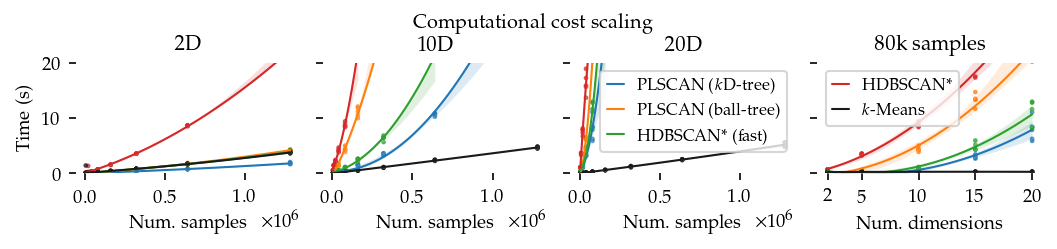

In [10]:
legend_ids = [[], [], [0, 1, 2], [3, 4]]
palette = ["C0", "C1", "C2", "C3", "k"]
ticks = [0, 10, 20]

sized_fig(1, 0.85 / 4)
for i, d in enumerate([2, 10, 20]):
    plt.subplot(1, 4, i + 1)
    plt.title(f"{d}D")
    for j, name in enumerate(alg_names):
        sns.regplot(
            benchmark_results.query(f"n_features == {d} & algorithm == '{name}'"),
            x="n_samples",
            y="elapsed_time",
            color=palette[j],
            order=2,
            line_kws={"linewidth": 1},
            scatter_kws={"s": 5, "edgecolor": "none"},
        )
    plt.xlabel("Num.~samples")
    plt.ylim(0, timeout)
    plt.yticks(ticks)
    if i == 0:
        plt.ylabel("Time (s)")
    else:
        plt.ylabel("")
        plt.gca().set_yticklabels(['' for t in ticks])
    if len(legend_ids[i]):
        plt.legend(
            handles=[
                plt.Line2D([0], [0], color=palette[idx], lw=1, label=to_display_name(alg_names[idx]))
                for idx in legend_ids[i]
            ],
            loc="upper right",
            handlelength=1,
        )
plt.subplot(1, 4, 4)
for i, name in enumerate(alg_names):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.regplot(
            benchmark_results.query(f"algorithm == '{name}' & n_samples == 80000"),
            x="n_features",
            y="elapsed_time",
            color=palette[i],
            order=2,
            line_kws={"linewidth": 1},
            scatter_kws={"s": 5, "edgecolor": "none"},
        )
if len(legend_ids[-1]):
    plt.legend(
        handles=[
            plt.Line2D([0], [0], color=palette[idx], lw=1, label=to_display_name(alg_names[idx]))
            for idx in legend_ids[-1]
        ],
        loc="upper left",
        handlelength=1,
    )
plt.xticks([2, 5, 10, 15, 20])
plt.ylim(0, timeout)
plt.yticks(ticks)
plt.gca().set_yticklabels(['' for t in ticks])
plt.ylabel("")
plt.xlabel("Num.~dimensions")
plt.title("80k samples")
plt.suptitle("Computational cost scaling", y=1)

plt.subplots_adjust(0.06, 0.28, 0.99, 0.78, wspace=0.1)
plt.savefig("images/benchmark_time.pdf", pad_inches=0)
plt.show()